# Install dependecies

In [1]:
!pip install tensorflow==2.4.1 opencv-python matplotlib

You should consider upgrading via the '/Users/sanjeev/Documents/faceid/faceid/bin/python3 -m pip install --upgrade pip' command.


# Import dependencies

In [7]:
#standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [8]:
#tensorflow dependencies- Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [9]:
#Setup paths
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative')
ANC_PATH = os.path.join('data','anchor')

In [5]:
#making directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [6]:
#uncompress tar gz labelled faces in the wild dataset
!tar -xf lfw.tgz

In [10]:
#Move lfw images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        EX_PATH = os.path.join('lfw',directory,file)
        NEW_PATH = os.path.join(NEG_PATH,file)
        os.replace(EX_PATH,NEW_PATH)

FileNotFoundError: [Errno 2] No such file or directory: 'lfw'

In [3]:
#import uuid to generate unique image names
import uuid

In [10]:
#establish a connection to the webcame
cap = cv2.VideoCapture(0)
while cap.isOpened(): #loop through frames till the webcam is open
    ret,frame = cap.read() #read frames at every point in time
    
    frame = frame[130:130+250,530:530+250,:] #cut down frame to 250 X 250
    
    if cv2.waitKey(1) & 0XFF == ord('a'): #collecting anchor images
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())) #create the unique file path
        cv2.imwrite(imgname, frame) #write out anchor image
        
    if cv2.waitKey(1) & 0XFF == ord('p'): #collecting positive images
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    cv2.imshow('Image Collection', frame) #rendering the frame back to the screen
    
    if cv2.waitKey(1) & 0XFF == ord('q'): #breaking
        break
        
cap.release() #release the webcam
cv2.destroyAllWindows() #close the image show frame

In [12]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [13]:
dir_test = anchor.as_numpy_iterator()

In [14]:
dir_test.next()

b'data/anchor/19f62652-cc9e-11ec-8297-1094bbdfb49c.jpg'

In [15]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path) #read in image from file path
    img = tf.io.decode_jpeg(byte_img) #load in the image
    img = tf.image.resize(img,(100,100)) #resizing image to 100 X 100 X 3
    img = img / 255.0 #scaling the image between 0 and 1
    return img

In [16]:
positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [17]:
data

<ConcatenateDataset shapes: ((), (), ()), types: (tf.string, tf.string, tf.float32)>

In [18]:
samples = data.as_numpy_iterator()

In [21]:
example = samples.next()

In [20]:
def preprocess_twin(input_img,validation_img,label):
    return (preprocess(input_img),preprocess(validation_img),label)

In [23]:
res = preprocess_twin(*example)

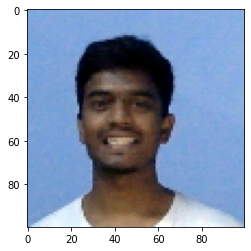

In [27]:
plt.imshow(res[0])

In [28]:
res[2]

1.0

In [29]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

In [32]:
samples = data.as_numpy_iterator()

In [34]:
len(samples.next())

3

In [35]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [37]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)